In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
import pymysql
import joblib

import warnings
warnings.filterwarnings("ignore")

MySQL 연결

In [2]:
DB_USER = "root"
DB_PASSWORD = "fls0413!"
DB_HOST = "localhost"
DB_PORT = 3306
DB_NAME = "core5_ems"

engine = create_engine(
    f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}",
    echo=False
)

DB에서 Core4 + IoT 데이터 로드

In [3]:
# EMS/ESS (전력 기반 구조)
core4 = pd.read_sql(
    "SELECT * FROM ems_ess_core4",
    engine,
    parse_dates=["timestamp"]
).set_index("timestamp")

# 의료 IoT (페이스메이커)
iot = pd.read_sql(
    "SELECT * FROM pacemaker_iot",
    engine
)

core4.shape, iot.shape

((8760, 6), (15000, 27))

의료 IoT → EMS 구조 매핑
전력 ↔ 의료 구조 치환

In [4]:
iot2 = iot.copy()

iot2["heart_rate"] = iot2["current_hr"]
iot2["reserve_level"] = 1.0 - (iot2["arrhythmia_risk"])   # ESS SOC 대응
iot2["trend_signal"] = iot2["next_hr"] - iot2["current_hr"]

iot2 = iot2[[
    "heart_rate",
    "reserve_level",
    "trend_signal"
]]

iot2.head()

,heart_rate,reserve_level,trend_signal
0,90.841650,0.630627,-3.085551
1,87.756099,0.658407,-4.775805
2,82.980294,0.680082,-0.881633
3,82.098661,0.702290,-1.543977
4,80.554684,0.736381,4.750851


공통 EMS 규칙 정의

In [5]:
threshold = iot2["heart_rate"].quantile(0.95)
alpha = 0.10

threshold, alpha

(np.float64(94.51940472849407), 0.1)

In [6]:
model = joblib.load("../models/core4_integrated_model.pkl")
model

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('imp', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If a featur

EMS 판단 입력 구성

In [7]:
X_iot = pd.DataFrame({
    "state": iot2["heart_rate"],
    "trend": iot2["trend_signal"],
    "reserve": iot2["reserve_level"]
}).dropna()

X_iot.shape

(15000, 3)

EMS 개입 결정 (Reactive vs Proactive)

In [8]:
# Reactive: 현재 상태 기준
signal_reactive = X_iot["state"]

# Proactive: 다음 상태 기준
signal_proactive = X_iot["state"].shift(-1).fillna(method="ffill")

def ems_control(signal):
    return np.where(
        signal > threshold,
        alpha * (signal - threshold),
        0.0
    )

intervention_re = ems_control(signal_reactive)
intervention_pr = ems_control(signal_proactive)

제어 결과 테이블 생성

In [10]:
threshold, iot2["heart_rate"].min(), iot2["heart_rate"].max()

(np.float64(94.51940472849407),
 np.float64(40.0),
 np.float64(121.8162157448594))

In [9]:
control = pd.DataFrame({
    "heart_rate": X_iot["state"],
    "reactive_intervention": intervention_re,
    "proactive_intervention": intervention_pr
})

control["after_reactive"] = control["heart_rate"] - control["reactive_intervention"]
control["after_proactive"] = control["heart_rate"] - control["proactive_intervention"]

control.head()

,heart_rate,reactive_intervention,proactive_intervention,after_reactive,after_proactive
0,90.841650,0.0,0.0,90.841650,90.841650
1,87.756099,0.0,0.0,87.756099,87.756099
2,82.980294,0.0,0.0,82.980294,82.980294
3,82.098661,0.0,0.0,82.098661,82.098661
4,80.554684,0.0,0.0,80.554684,80.554684


결과 저장

In [11]:
control.reset_index(drop=True).to_sql(
    name="core5_control_result",
    con=engine,
    if_exists="replace",
    index=False
)

15000

해석용 시각화

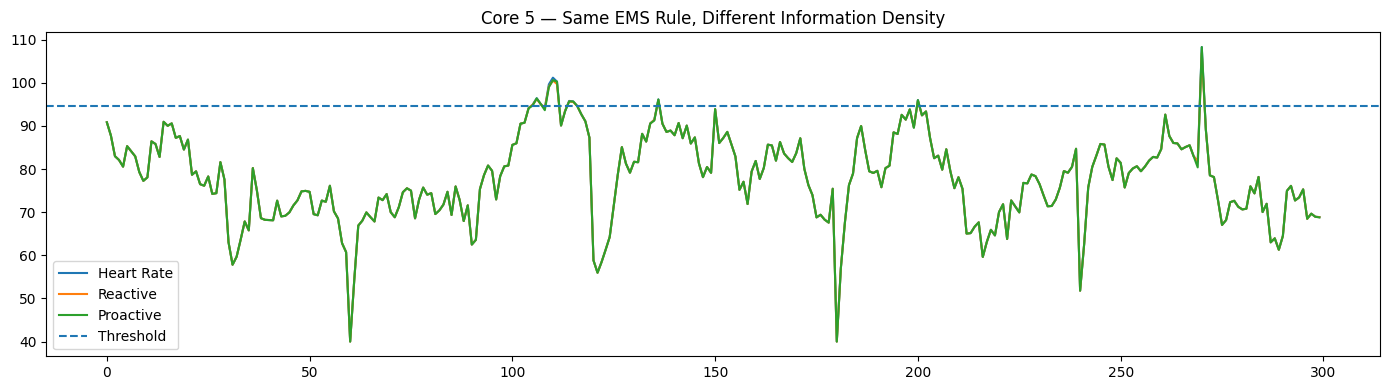

In [12]:
n = 300

plt.figure(figsize=(14,4))
plt.plot(control["heart_rate"].values[:n], label="Heart Rate")
plt.plot(control["after_reactive"].values[:n], label="Reactive")
plt.plot(control["after_proactive"].values[:n], label="Proactive")
plt.axhline(threshold, linestyle="--", label="Threshold")
plt.legend()
plt.title("Core 5 — Same EMS Rule, Different Information Density")
plt.tight_layout()
plt.show()

같은 예측 모델과 동일한 EMS 규칙을 사용하더라도,
의료 IoT 환경에서는 상태 정보 밀도 차이로 인해
제어 개입의 시점과 효과가 구조적으로 달라진다.